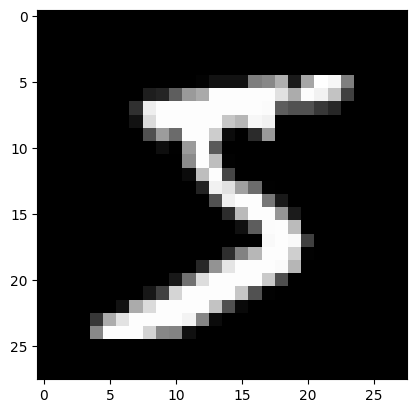

In [2]:

import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

numb_batch=64

T=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data=torchvision.datasets.MNIST('mnist data', train=True, download=True, transform=T)
val_data=torchvision.datasets.MNIST('mnist data', train=False, download=False, transform=T)

train_dl=torch.utils.data.DataLoader(train_data,batch_size=numb_batch)
val_dl=torch.utils.data.DataLoader(val_data,batch_size=numb_batch)
plt.imshow(train_data[0][0][0], cmap="gray")

device: cpu
Saving best model with accuracy: 96.81999969482422
Epoch:1,Accuracy:96.81999969482422%
Saving best model with accuracy: 97.77999877929688
Epoch:2,Accuracy:97.77999877929688%


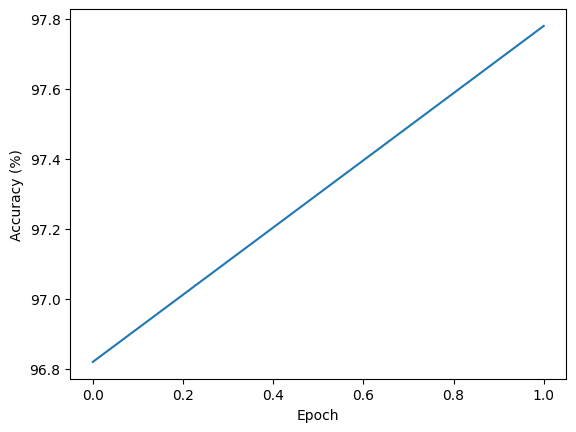

In [3]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.Linear(120, 84),
        nn.Linear(84, 10)
    )
    return model

def validate(model, data, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(data):
            images = images.cpu()
            x=model(images)
            value,pred = torch.max(x,1)
            pred=pred.data.cpu()
            total+=x.size(0)
            correct+=torch.sum(pred==labels)
    model.train()
    return correct*100/total

def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    best_model = None
    for epoch in range(numb_epoch):
        for images, labels in train_dl:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = cec(outputs, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(model=cnn, data=val_dl, device=device))
        accuracies.append(accuracy)
        if accuracy>max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving best model with accuracy:",accuracy)
        print(f"Epoch:{epoch+1},Accuracy:{accuracy}%")
    plt.plot(accuracies)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.show()
    return best_model
if torch.cuda.is_available():
  device=torch.device("cuda:0")
else:
  device=torch.device("cpu")
print("device:", device)

lenet = train(numb_epoch=2, lr=1e-3, device=device)

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
def predict_dl(model,data):
    y_pred=[]
    y_true=[]
    for i,(images,labels) in enumerate(data):
        images=images.cpu()
        x=model(images)
        value,pred=torch.max(x,1)
        pred=pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred),np.array(y_true)
y_pred,y_true = predict_dl(lenet,val_dl)
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,969,0,1,0,0,1,3,1,5,0
1,0,1131,1,1,0,0,0,1,1,0
2,1,9,995,10,1,0,0,3,12,1
3,1,0,2,982,0,14,0,7,2,2
4,2,0,1,0,971,0,1,1,1,5
5,1,1,0,3,0,883,1,1,2,0
6,3,6,0,0,2,24,914,0,9,0
7,1,6,9,2,0,1,0,1003,1,5
8,3,0,3,7,2,0,0,2,952,5
9,4,5,0,3,8,6,0,4,1,978


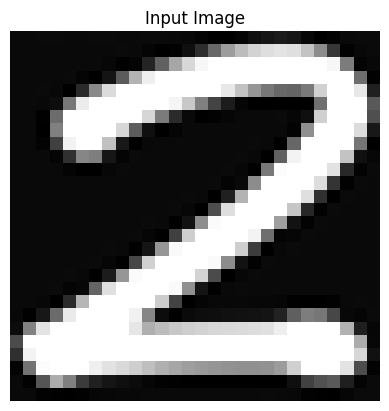

Predicted: 2, Probability: 99.86%


In [9]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
def inference(path,model,device):
    r=requests.get(path)
    with BytesIO(r.content) as f:
        img=Image.open(f).convert(mode="L")
        img=img.resize((28,28))
        x=(255-np.expand_dims(np.array(img),-1))/255
    with torch.no_grad():
        pred=model(torch.unsqueeze(T(x),axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()
        
image_url = "https://www.clipartmax.com/png/middle/96-965294_2-hand-written-number-2.png"

# Display the image
headers = {'User-Agent': 'Mozilla/5.0'}
r = requests.get(image_url, headers=headers)
with BytesIO(r.content) as f:
    img = Image.open(f).convert("L")
    img = img.resize((28, 28))
    arr = 255 - np.array(img)
    arr = arr / 255.0
    plt.imshow(arr, cmap="gray")
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

# Run inference
pred = inference(image_url, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Probability: {pred[0][pred_idx] * 100:.2f}%")

In [19]:
import numpy as np
dig = 7
manual_one_hot = np.zeros(10)
manual_one_hot[dig] = 1
print(f"Manual dig:{dig}")
print(f"One-hot encoded vector: {manual_one_hot}")


Manual dig:7
One-hot encoded vector: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [23]:
pred_dig = np.argmax(pred)
sum = pred_dig + dig
sum_one_hot = np.zeros(10)
sum_one_hot[sum] = 1
print(f"Model Dig:{pred_dig}")
print(f"One-hot dig:{dig}")
print(f"Sum:{sum}")
print(f"One-hot encoded sum vector:{sum_one_hot.astype(int)}")

Model Dig:2
One-hot dig:7
Sum:9
One-hot encoded sum vector:[0 0 0 0 0 0 0 0 0 1]
